In [1]:
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pygal
from mpl_toolkits.mplot3d import Axes3D
from functools import reduce

import datetime
from datetime import date

from varclushi import VarClusHi

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import tensorflow as tf

from scikitplot.plotters import plot_roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,roc_auc_score
pd.set_option('display.max_columns', 500)


# Loading Transformed Data

In [2]:
dfp = pd.read_csv("airbnb_rooms_final.csv")

In [35]:
df = dfp.copy()

In [36]:
df.shape

(54103, 78)

## First Clean

In [37]:
coldrop = [i for i in df.columns if i.find("_y") !=-1]
coldrop = coldrop + ["Name_x", "Host ID_x", "Neighbourhood", "Coordinates", "Location",
           "Listing Url", "Summary", "Description", "Host Name", "Host Location",
           "Host Response Time", "Host Neighbourhood","Host Verifications","Street",
           "Neighbourhood Cleansed","State", "Zipcode", "Market", "Smart Location", "Country Code",
           "Latitude","Longitude", "Calendar Updated", "Calendar last Scraped","Geolocation","Features",
          "Host Response Rate", "Reviews per Month","Experiences Offered", "Date last review","Room Type",
                    "Availibility", "Bed Type", "Amenities", "Price", "Availability 30",
                    "Availability 60", "Availability 90", "Availability 365", "Room ID", "Number of reviews",
                    "Host Total Listings Count", "Minimum nights", "Calculated host listings count",
                    "Maximum Nights"]

df = df.drop(coldrop, axis = 1)

df = df[(df['First Review'].isna() == False) & (df['Last Review'].isna() == False) &
       (df['Updated Date'].isna() == False) & (df['Host Since'].isna() == False)].copy()

df = df.rename(columns = {"City_x": "City", "Country_x":"Country"})
df["Cleaning Fee"] = df["Cleaning Fee"].fillna(0, inplace = True) 

df.shape

(41194, 29)

In [38]:
for i in df.columns:
    print(i, round(df[i].isna().sum()/len(df),3))

Room type 0.0
Room Price 0.0
Number of reviews per month 0.0
Rooms rent by the host 0.0
Updated Date 0.0
City 0.0
Country 0.0
Host Since 0.0
Host Listings Count 0.0
Property Type 0.0
Accommodates 0.0
Bathrooms 0.003
Bedrooms 0.001
Beds 0.001
Cleaning Fee 1.0
Guests Included 0.0
Extra People 0.0
Minimum Nights 0.0
Number of Reviews 0.0
First Review 0.0
Last Review 0.0
Review Scores Rating 0.014
Review Scores Accuracy 0.016
Review Scores Cleanliness 0.016
Review Scores Checkin 0.017
Review Scores Communication 0.015
Review Scores Location 0.017
Review Scores Value 0.017
Cancellation Policy 0.0


In [39]:
df.head()

,Room type,Room Price,Number of reviews per month,Rooms rent by the host,Updated Date,City,Country,Host Since,Host Listings Count,Property Type,Accommodates,Bathrooms,Bedrooms,Beds,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Number of Reviews,First Review,Last Review,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Cancellation Policy
0,Entire home/apt,70,0.04,1,2020-05-10,Paris,France,2015-05-02,1.0,Apartment,2.0,1.0,1.0,1.0,None,1.0,0.0,1.0,2.0,2016-07-21,2016-07-24,100.0,10.0,9.0,10.0,9.0,10.0,10.0,flexible
1,Private room,44,0.95,1,2020-06-11,Sydney,Australia,2015-07-17,1.0,Apartment,2.0,1.0,1.0,1.0,None,1.0,0.0,5.0,2.0,2016-06-24,2016-07-03,80.0,8.0,9.0,8.0,8.0,8.0,9.0,flexible
3,Entire home/apt,68,0.02,1,2020-05-10,London,United kingdom,2013-05-29,1.0,Apartment,2.0,1.0,1.0,1.0,None,1.0,0.0,2.0,1.0,2015-09-08,2015-09-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,moderate
4,Entire home/apt,195,0.49,1,2020-05-10,Paris,France,2014-12-13,1.0,Apartment,6.0,2.0,2.0,2.0,None,6.0,30.0,30.0,31.0,2015-01-02,2016-08-03,94.0,10.0,9.0,10.0,10.0,10.0,9.0,moderate
5,Private room,20,0.22,1,2020-05-14,Berlin,Germany,2013-08-07,1.0,Apartment,2.0,1.0,1.0,1.0,None,1.0,10.0,2.0,9.0,2013-08-26,2017-04-06,84.0,9.0,9.0,10.0,9.0,10.0,9.0,strict


## Breaking down dates and generating new variables

In [40]:
def fechas(df):
    df["Year last review"] = df['Last Review'].apply( lambda x: int(x.split("-")[0]))
    df["Month last review"] = df['Last Review'].apply( lambda x: int(x.split("-")[1]))
    df["Day last review"] = df['Last Review'].apply( lambda x: int(x.split("-")[2]))
    
    df["Date last review"] = df.apply(lambda row: pd.Timestamp(date(row["Year last review"],
                                        row["Month last review"],row["Day last review"])).date(), axis = 1)

    df["Days since last review"] = (df["Date last review"].max() - df["Date last review"]).dt.days

    df["Year First Review"] = df['First Review'].apply( lambda x: int(x.split("-")[0]))
    df["Month First Review"] = df['First Review'].apply( lambda x: int(x.split("-")[1]))
    df["Day First Review"] = df['First Review'].apply( lambda x: int(x.split("-")[2]))
    
    df["Date first review"] = df.apply(lambda row: pd.Timestamp(date(row["Year First Review"],
                                        row["Month First Review"],row["Day First Review"])).date(), axis = 1)

    df["Months of the product in Airbnb"] = (df["Date last review"].max() - df["Date first review"]).dt.days/30
    
    
    df["Year Updated Date"] = df['Updated Date'].apply( lambda x: int(x.split("-")[0]))
    df["Month Updated Date"] = df['Updated Date'].apply( lambda x: int(x.split("-")[1]))
    df["Day Updated Date"] = df['Updated Date'].apply( lambda x: int(x.split("-")[2]))
    
    df["Updated Date"] = df.apply(lambda row: pd.Timestamp(date(row["Year Updated Date"],
                                        row["Month Updated Date"],row["Day Updated Date"])).date(), axis = 1)

    df["Days since last update"] = (df["Updated Date"].max() - df["Updated Date"]).dt.days
    
    
    df["Year Host Since"] = df['Host Since'].apply( lambda x: int(x.split("-")[0]))
    df["Month Host Since"] = df['Host Since'].apply( lambda x: int(x.split("-")[1]))
    df["Day Host Since"] = df['Host Since'].apply( lambda x: int(x.split("-")[2]))
    
    df["Host Since"] = df.apply(lambda row: pd.Timestamp(date(row["Year Host Since"],
                                        row["Month Host Since"],row["Day Host Since"])).date(), axis = 1)

    df["Months Since is Host"] = (df["Date last review"].max() - df["Host Since"]).dt.days/30
    
    
    coldrop = ["Year last review", "Month last review", "Day last review",
              "Year First Review", "Month First Review", "Day First Review", "Date first review",
              "Year Updated Date", "Month Updated Date", "Day Updated Date", "Updated Date",
              "Year Host Since", "Month Host Since", "Day Host Since", "Host Since", "Date last review",
              "First Review","Last Review"]
    df = df.drop(coldrop, axis = 1)
    
    return df

In [41]:
df = fechas(df)

In [42]:
df.head()

,Room type,Room Price,Number of reviews per month,Rooms rent by the host,City,Country,Host Listings Count,Property Type,Accommodates,Bathrooms,Bedrooms,Beds,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Number of Reviews,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Cancellation Policy,Days since last review,Months of the product in Airbnb,Days since last update,Months Since is Host
0,Entire home/apt,70,0.04,1,Paris,France,1.0,Apartment,2.0,1.0,1.0,1.0,None,1.0,0.0,1.0,2.0,100.0,10.0,9.0,10.0,9.0,10.0,10.0,flexible,326,10.966667,33,25.833333
1,Private room,44,0.95,1,Sydney,Australia,1.0,Apartment,2.0,1.0,1.0,1.0,None,1.0,0.0,5.0,2.0,80.0,8.0,9.0,8.0,8.0,8.0,9.0,flexible,347,11.866667,1,23.300000
3,Entire home/apt,68,0.02,1,London,United kingdom,1.0,Apartment,2.0,1.0,1.0,1.0,None,1.0,0.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,moderate,646,21.533333,33,49.266667
4,Entire home/apt,195,0.49,1,Paris,France,1.0,Apartment,6.0,2.0,2.0,2.0,None,6.0,30.0,30.0,31.0,94.0,10.0,9.0,10.0,10.0,10.0,9.0,moderate,316,29.833333,33,30.500000
5,Private room,20,0.22,1,Berlin,Germany,1.0,Apartment,2.0,1.0,1.0,1.0,None,1.0,10.0,2.0,9.0,84.0,9.0,9.0,10.0,9.0,10.0,9.0,strict,70,46.300000,29,46.933333


/Users/Victor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10b33bad0>,
      dtype=object)

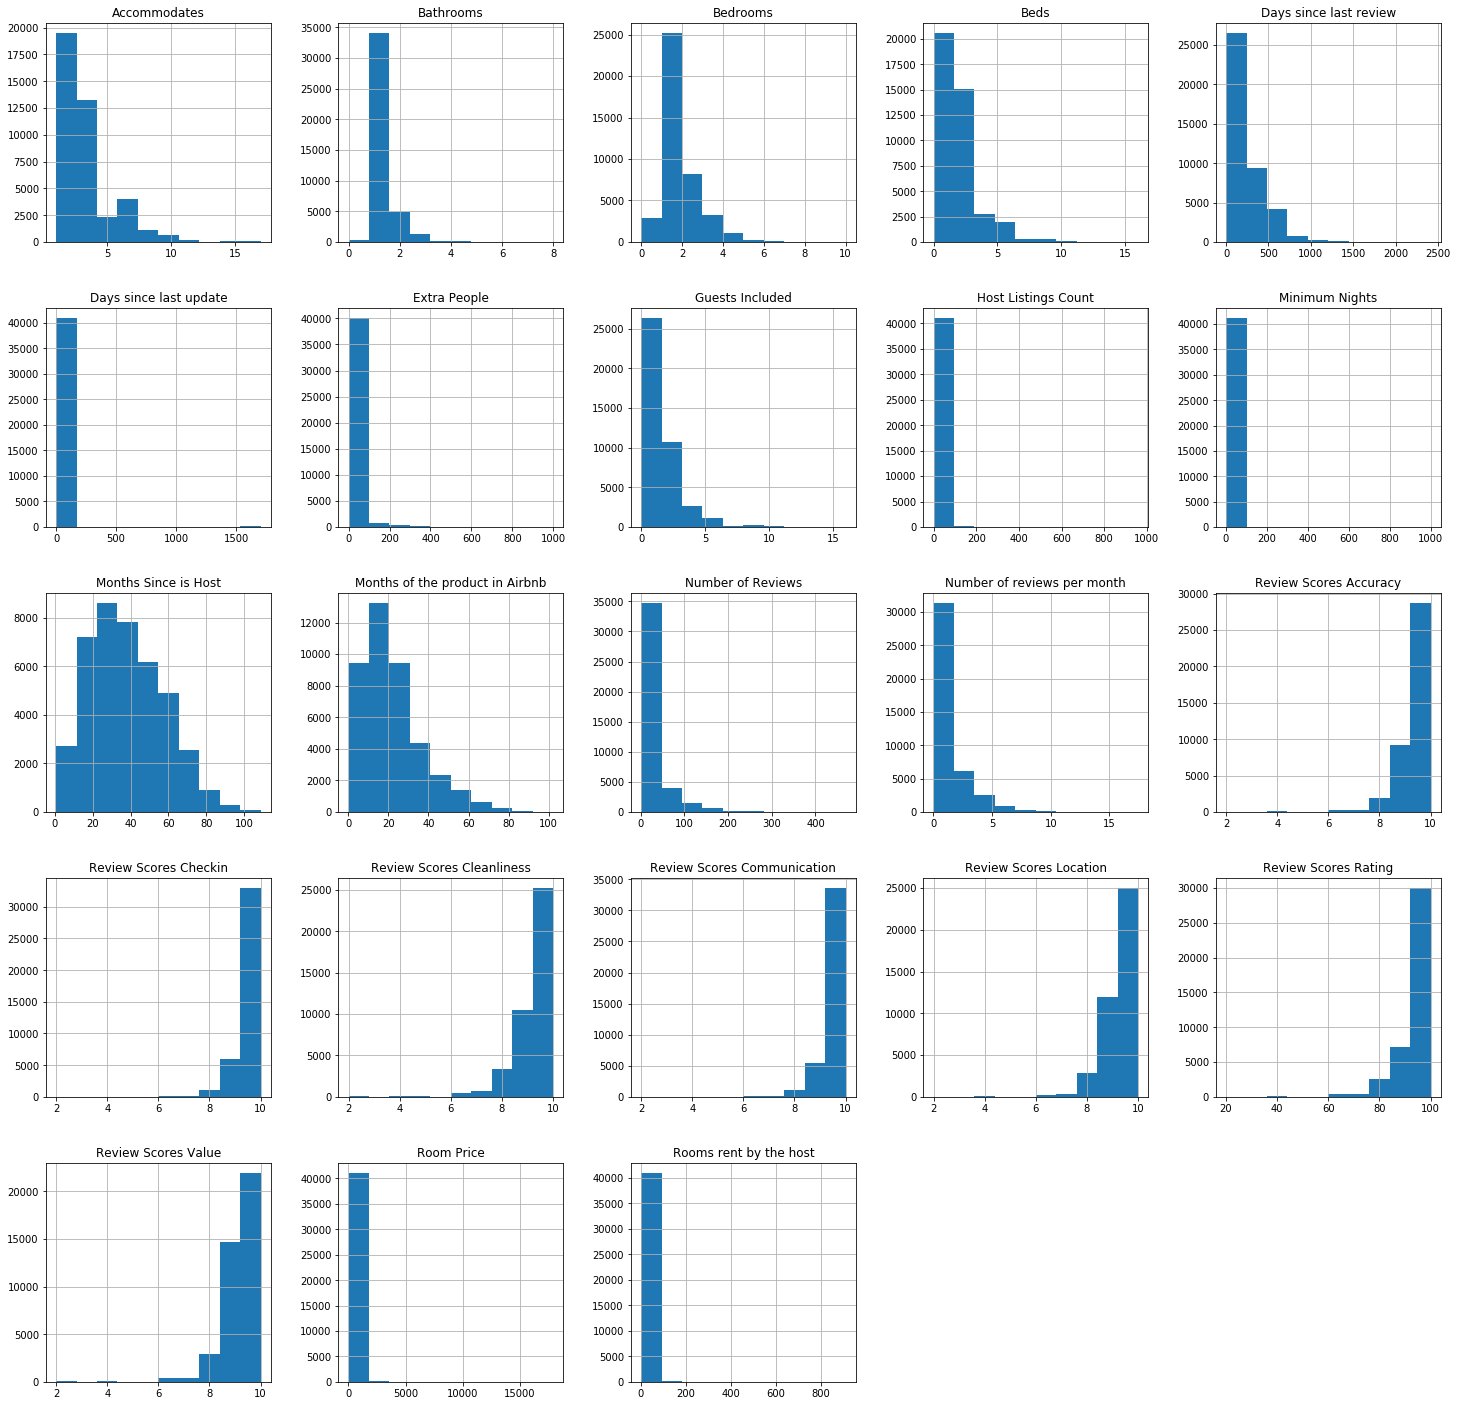

In [43]:
fig = plt.figure(figsize = (25,25))
ax = fig.gca()
df.hist(ax = ax)

In [44]:
vard = ['Accommodates','Bathrooms','Bedrooms','Beds','Cancellation Policy','City','Country',"Guests Included"]

varc = [x for x in df.columns if x not in vard]



# Análisis Exploratorio Discreto

## Normalización

In [45]:
def normalizar(df,v,th=0.05):
    df2 = df.copy()
    aux = df2[v].fillna('NULL').value_counts(True).to_frame()
    aux['agrupar'] = aux[v]<th
    aux['norm'] = np.where(aux['agrupar'],'RESTO',aux.index)
    if aux.loc[aux['norm']=='RESTO'][v].sum()<th:
        aux['norm'].replace({'RESTO':aux.head(1)['norm'].values},inplace=True)
    aux = aux[['norm']] 
    df2['n_%s'%v] = df2[v].fillna('NULL').replace(aux.to_dict()['norm'])
    return df2.copy()

In [46]:
for v in vard:
    df = normalizar(df,v)

In [47]:
df.shape

(41194, 37)

In [48]:
varn = [v for v in df.columns if v[:2]=='n_']

In [49]:
def freq(df,var):
    
    if type(var)!=list:
        var = [var]
    for v in var:
        print("frecuencias para la variable %s"%v,end='\n\n')
        aux = df[v].fillna('NULL').value_counts().to_frame()
        aux.rename(columns={v:'fa'},inplace=True)
        aux['fr'] = aux['fa']/aux['fa'].sum()
        aux['faa'] = aux['fa'].cumsum()
        aux['fra'] = aux['fr'].cumsum()
        print(aux,end='\n\n')

In [50]:
freq(df,varn)

frecuencias para la variable n_Accommodates

          fa        fr    faa       fra
2.0    16794  0.407681  16794  0.407681
4.0     9097  0.220833  25891  0.628514
3.0     4195  0.101835  30086  0.730349
6.0     3330  0.080837  33416  0.811186
RESTO   2768  0.067194  36184  0.878380
1.0     2689  0.065276  38873  0.943657
5.0     2321  0.056343  41194  1.000000

frecuencias para la variable n_Bathrooms

          fa        fr    faa       fra
1.0    31739  0.770476  31739  0.770476
2.0     4849  0.117711  36588  0.888188
RESTO   2329  0.056537  38917  0.944725
1.5     2277  0.055275  41194  1.000000

frecuencias para la variable n_Bedrooms

        fa        fr    faa       fra
1.0  26706  0.648298  26706  0.648298
2.0   8239  0.200005  34945  0.848303
3.0   3300  0.080109  38245  0.928412
0.0   2949  0.071588  41194  1.000000

frecuencias para la variable n_Beds

          fa        fr    faa       fra
1.0    20558  0.499053  20558  0.499053
2.0    10667  0.258945  31225  0.757999
3.

## Unarias

In [51]:
unarias = [x for x,y in map(lambda v:(v,df[v].unique().shape[0]),varn) if y==1]
unarias

[]

In [52]:
df.drop(unarias,axis=1,inplace=True)

In [53]:
varn = [v for v in varn if v not in unarias]
varn

['n_Accommodates',
 'n_Bathrooms',
 'n_Bedrooms',
 'n_Beds',
 'n_Cancellation Policy',
 'n_City',
 'n_Country',
 'n_Guests Included']

In [54]:
freq(df,varn)

frecuencias para la variable n_Accommodates

          fa        fr    faa       fra
2.0    16794  0.407681  16794  0.407681
4.0     9097  0.220833  25891  0.628514
3.0     4195  0.101835  30086  0.730349
6.0     3330  0.080837  33416  0.811186
RESTO   2768  0.067194  36184  0.878380
1.0     2689  0.065276  38873  0.943657
5.0     2321  0.056343  41194  1.000000

frecuencias para la variable n_Bathrooms

          fa        fr    faa       fra
1.0    31739  0.770476  31739  0.770476
2.0     4849  0.117711  36588  0.888188
RESTO   2329  0.056537  38917  0.944725
1.5     2277  0.055275  41194  1.000000

frecuencias para la variable n_Bedrooms

        fa        fr    faa       fra
1.0  26706  0.648298  26706  0.648298
2.0   8239  0.200005  34945  0.848303
3.0   3300  0.080109  38245  0.928412
0.0   2949  0.071588  41194  1.000000

frecuencias para la variable n_Beds

          fa        fr    faa       fra
1.0    20558  0.499053  20558  0.499053
2.0    10667  0.258945  31225  0.757999
3.

# Análisis Exploratorio Continuo

## Missings

In [55]:
miss = 1-df[varc].describe().T[['count']]/len(dfp)
miss = miss.loc[miss['count']<=0.3]

In [56]:
varc = [v for v in miss.index]

In [57]:
df[varc].dropna().shape[0]/df[varc].shape[0]

0.9810409282905277

In [58]:
df = df[varc + vard].copy()

In [59]:
df.head()

,Room Price,Number of reviews per month,Rooms rent by the host,Host Listings Count,Extra People,Minimum Nights,Number of Reviews,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Days since last review,Months of the product in Airbnb,Days since last update,Months Since is Host,Accommodates,Bathrooms,Bedrooms,Beds,Cancellation Policy,City,Country,Guests Included
0,70,0.04,1,1.0,0.0,1.0,2.0,100.0,10.0,9.0,10.0,9.0,10.0,10.0,326,10.966667,33,25.833333,2.0,1.0,1.0,1.0,flexible,Paris,France,1.0
1,44,0.95,1,1.0,0.0,5.0,2.0,80.0,8.0,9.0,8.0,8.0,8.0,9.0,347,11.866667,1,23.300000,2.0,1.0,1.0,1.0,flexible,Sydney,Australia,1.0
3,68,0.02,1,1.0,0.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,646,21.533333,33,49.266667,2.0,1.0,1.0,1.0,moderate,London,United kingdom,1.0
4,195,0.49,1,1.0,30.0,30.0,31.0,94.0,10.0,9.0,10.0,10.0,10.0,9.0,316,29.833333,33,30.500000,6.0,2.0,2.0,2.0,moderate,Paris,France,6.0
5,20,0.22,1,1.0,10.0,2.0,9.0,84.0,9.0,9.0,10.0,9.0,10.0,9.0,70,46.300000,29,46.933333,2.0,1.0,1.0,1.0,strict,Berlin,Germany,1.0


In [60]:
len(varc)

18

## Multicolinealidad

In [61]:
vc = VarClusHi(df[varc].dropna(),varc,maxclus=7)
vc.varclus()

In [62]:
aux = vc.rsquare.sort_values(by=['Cluster','RS_Ratio']).reset_index(drop=True)
aux['i'] = aux.groupby('Cluster').cumcount()+1
aux = aux.loc[aux['i']==1]
mc_varc = aux['Variable'].tolist()
mc_varc

['Review Scores Rating',
 'Number of reviews per month',
 'Rooms rent by the host',
 'Months Since is Host',
 'Days since last update']

In [63]:
df.shape

(41194, 26)

In [64]:
df[mc_varc].sample(frac = 0.1).to_csv("mc_varc.csv", index = False)

In [65]:
mc_varc

['Review Scores Rating',
 'Number of reviews per month',
 'Rooms rent by the host',
 'Months Since is Host',
 'Days since last update']

In [96]:
(pd.cut(df['Review Scores Rating'] , bins = [60,70,80,90,100]).value_counts()/len(df))

(90, 100]    0.757149
(80, 90]     0.155217
(70, 80]     0.057484
(60, 70]     0.005243
Name: Review Scores Rating, dtype: float64

In [69]:
import plotly.express as px
fig = px.histogram(df, x='Review Scores Rating', nbins = 13)
fig.show()

## Univariado

In [1186]:
df[mc_varc].describe(percentiles=[0.01,0.99])

,Review Scores Rating,Number of reviews per month,Rooms rent by the host,Months Since is Host,Days since last update
count,40619.000000,41191.000000,41194.000000,41194.000000,41194.000000
mean,93.826830,1.198566,4.991091,37.749118,32.717435
std,7.634116,1.543988,25.683596,19.438941,138.107714
min,20.000000,0.010000,1.000000,0.666667,0.000000
1%,60.000000,0.020000,1.000000,4.464333,1.000000
50%,96.000000,0.560000,1.000000,35.700000,27.000000
99%,100.000000,6.800000,73.000000,86.100000,35.000000
max,100.000000,17.440000,910.000000,108.700000,1705.000000


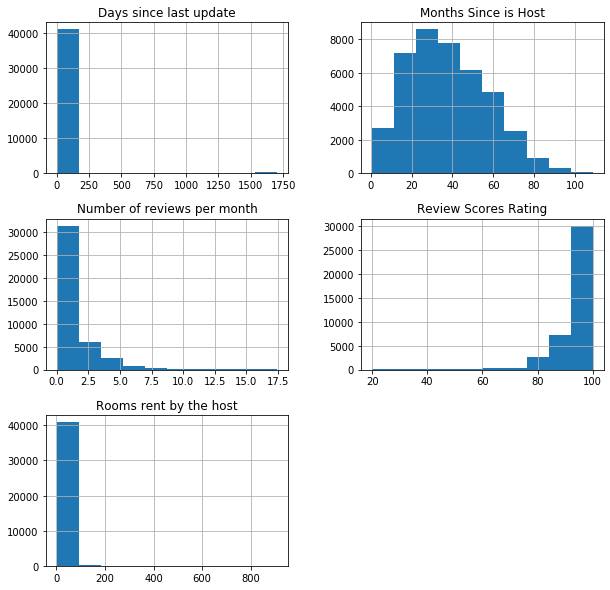

In [1187]:
df[mc_varc].hist(figsize=(10,10))
plt.savefig("histograms.png")

## Outliers

In [1188]:
ol = np.array(df.describe(percentiles=[0.01,0.05,0.95,0.99]).T[['1%','99%']].reset_index())

def extremos(df,v,lb,ub):
    aux = df[[v]].copy()
    aux['ol_%s'%v] = ((aux[v]<lb)|(aux[v]>ub)).astype(int)
    return aux.drop(v,axis=1)

ol = reduce(lambda x,y:pd.merge(x,y,how='outer',left_index=True, right_index=True),map(lambda z:extremos(df,*z),ol))

ol['extremo'] = ((ol.filter(like='ol_').sum(axis=1))>1).astype(int)

ol['extremo'].value_counts(True)

0    0.953974
1    0.046026
Name: extremo, dtype: float64

In [1189]:
df = df.merge(ol[ol['extremo']!=1],how='inner',left_index=True, right_index=True)
df = df.drop([var for var in df.columns if var.startswith(("ol","extremo"))], axis = 1)

In [1190]:
#tad = pd.get_dummies(df, columns=['Room Type','City_x', 'Country_x'])
tad = df.copy()

In [1191]:
tad.head()

,Room Price,Number of reviews per month,Rooms rent by the host,Host Listings Count,Extra People,Minimum Nights,Number of Reviews,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Days since last review,Months of the product in Airbnb,Days since last update,Months Since is Host,Accommodates,Bathrooms,Bedrooms,Beds,Cancellation Policy,City,Country,Guests Included
0,70,0.04,1,1.0,0.0,1.0,2.0,100.0,10.0,9.0,10.0,9.0,10.0,10.0,326,10.966667,33,25.833333,2.0,1.0,1.0,1.0,flexible,Paris,France,1.0
1,44,0.95,1,1.0,0.0,5.0,2.0,80.0,8.0,9.0,8.0,8.0,8.0,9.0,347,11.866667,1,23.300000,2.0,1.0,1.0,1.0,flexible,Sydney,Australia,1.0
3,68,0.02,1,1.0,0.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,646,21.533333,33,49.266667,2.0,1.0,1.0,1.0,moderate,London,United kingdom,1.0
4,195,0.49,1,1.0,30.0,30.0,31.0,94.0,10.0,9.0,10.0,10.0,10.0,9.0,316,29.833333,33,30.500000,6.0,2.0,2.0,2.0,moderate,Paris,France,6.0
5,20,0.22,1,1.0,10.0,2.0,9.0,84.0,9.0,9.0,10.0,9.0,10.0,9.0,70,46.300000,29,46.933333,2.0,1.0,1.0,1.0,strict,Berlin,Germany,1.0


## Clusters

In [405]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS,TSNE

In [406]:
varc

['Room Price',
 'Number of reviews per month',
 'Rooms rent by the host',
 'Host Listings Count',
 'Extra People',
 'Minimum Nights',
 'Number of Reviews',
 'Review Scores Rating',
 'Review Scores Accuracy',
 'Review Scores Cleanliness',
 'Review Scores Checkin',
 'Review Scores Communication',
 'Review Scores Location',
 'Review Scores Value',
 'Days since last review',
 'Months of the product in Airbnb',
 'Days since last update',
 'Months Since is Host']

In [380]:
col = ["Number of Reviews","Room Price",'Days since last review','Months of the product in Airbnb',
 'Days since last update','Months Since is Host']

In [464]:
col = varc

In [465]:
dfn = tad.sample(frac = 0.03)

In [466]:
X = dfn[col].copy()
X.shape

(1179, 18)

# Definición de Espacios

In [467]:
pi_std = make_pipeline(SimpleImputer(strategy='mean'),MinMaxScaler())
Xs = pd.DataFrame(pi_std.fit_transform(X),columns=col)

In [468]:
pi_pca = make_pipeline(SimpleImputer(strategy='median'),StandardScaler(),PCA(n_components=2))
Xp = pd.DataFrame(pi_pca.fit_transform(X),columns=['d1','d2']) 
print(pi_pca.steps[-1][-1].explained_variance_ratio_.cumsum())
Xp.head()

[0.20469647 0.32296555]


,d1,d2
0,-0.525963,0.189742
1,-1.748385,-0.657656
2,4.252130,4.772941
3,-0.305930,0.319230
4,-1.271262,-0.832073


In [469]:
pi_mds = make_pipeline(SimpleImputer(strategy='median'),MinMaxScaler(),MDS(n_components=2,n_jobs=-1))
Xm = pd.DataFrame(pi_mds.fit_transform(X),columns=['d1','d2']) 
Xm.head()

,d1,d2
0,0.031695,-0.019571
1,-0.368323,-0.386632
2,0.896733,0.527396
3,0.248923,0.554944
4,-0.204131,-0.032406


In [470]:
pi_tsne = make_pipeline(SimpleImputer(strategy='median'),MinMaxScaler(),TSNE(n_components=2))
Xt = pd.DataFrame(pi_tsne.fit_transform(X),columns=['d1','d2']) 
Xt.head()

,d1,d2
0,-3.912334,-7.355356
1,11.633051,17.843939
2,40.348343,-23.957750
3,27.941404,-2.183242
4,-33.527706,1.581256


# Visualización en $\mathbb{R}^2$

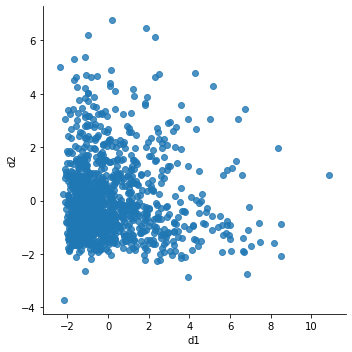

In [471]:
sns.lmplot(data=Xp,x='d1',y='d2',fit_reg=False)

In [499]:
Xp.to_csv("Xp.csv")

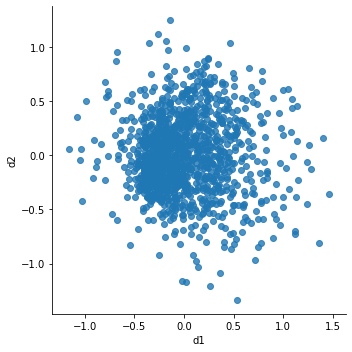

In [472]:
sns.lmplot(data=Xm,x='d1',y='d2',fit_reg=False)

In [500]:
Xm.to_csv("Xm.csv", index = False)

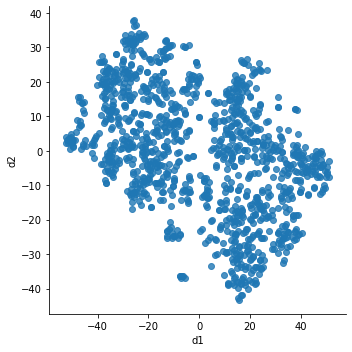

In [473]:
sns.lmplot(data=Xt,x='d1',y='d2',fit_reg=False)

In [501]:
Xt.to_csv("Xt.csv", index = False)

# Preclusterización

In [474]:
from sklearn.cluster import AgglomerativeClustering,KMeans
from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_score
from sklearn import metrics

In [475]:
l_in = []
for k in range(2,10):
    cl = KMeans(n_clusters=k,max_iter=len(X)*2)
    cl.fit(Xs)
    l_in.append(cl.inertia_)

In [502]:
l_in

[290.656797299037,
 252.3357498792415,
 234.46076686139327,
 223.6550118008377,
 213.84189278923847,
 206.08845218011652,
 197.90804540267976,
 190.23105443114144]

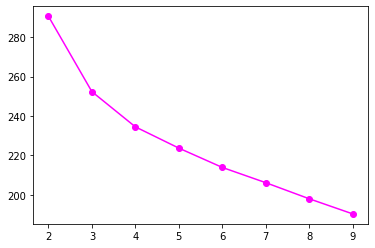

In [476]:
plt.plot(range(2,10),l_in,marker='o',color='magenta')

# Optimización

In [477]:
kme = KMeans(n_clusters=5,max_iter=len(X)*2)
dfn ['cl_kme'] = X['cl_kme'] = Xs['cl_kme'] = Xp['cl_kme'] = Xm['cl_kme'] = Xt['cl_kme'] = kme.fit_predict(Xs[col])

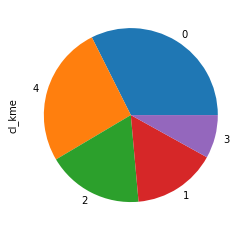

In [478]:
dfn.cl_kme.value_counts(True).plot(kind='pie')

In [504]:
dfn.cl_kme.value_counts(True)

0    0.324003
4    0.261238
2    0.178965
1    0.155216
3    0.080577
Name: cl_kme, dtype: float64

# Difuso

In [496]:
gmm = GaussianMixture(n_components=5,max_iter=len(X)*2)
dfn ['cl_gmm'] = X['cl_gmm'] = Xs['cl_gmm'] = Xp['cl_gmm'] = Xm['cl_gmm'] = Xt['cl_gmm'] = gmm.fit_predict(Xs[col])

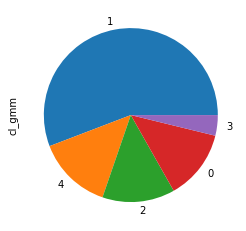

In [497]:
dfn.cl_gmm.value_counts(True).plot(kind='pie')

In [503]:
dfn.cl_gmm.value_counts(True)

1    0.558100
4    0.139101
2    0.134860
0    0.129771
3    0.038168
Name: cl_gmm, dtype: float64

# Perfilamiento

## Mejores variables para perfil

In [481]:
from sklearn.feature_selection import SelectKBest

sk = SelectKBest(k=8)
sk.fit(Xs[col],Xs['cl_kme'])

best = [x for x,y in zip(varc,sk.get_support()) if y]

In [482]:
best

['Number of Reviews',
 'Review Scores Rating',
 'Review Scores Accuracy',
 'Review Scores Cleanliness',
 'Review Scores Communication',
 'Review Scores Value',
 'Months of the product in Airbnb',
 'Months Since is Host']

## Variables estadísticamente relevantes para perfilar (estadígrafo de Kruskal)

In [483]:
from scipy.stats import ks_2samp
from scipy.stats import kruskal
from scipy.stats import chisquare
from statsmodels.stats.multicomp import MultiComparison

k = pd.DataFrame(map(lambda v:(v,kruskal(*[d[v] for _,d in Xs.groupby('cl_kme')]).pvalue),varc)).round(2)
k

,0,1
0,Room Price,0.00
1,Number of reviews per month,0.00
2,Rooms rent by the host,0.00
3,Host Listings Count,0.00
4,Extra People,0.00
5,Minimum Nights,0.00
6,Number of Reviews,0.00
7,Review Scores Rating,0.00
8,Review Scores Accuracy,0.00
9,Review Scores Cleanliness,0.00


## Pruebas Post-Hoc (tukey)

In [484]:
#Xs[['bc_open_to_buy','cl_kme']].groupby('cl_kme').mean()

In [485]:
for v in best:
    print(v)
    mc = MultiComparison(Xs[v],Xs['cl_kme'])
    print(mc.tukeyhsd().summary())
    print('\n')

Number of Reviews
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1   0.2039  0.001  0.1785  0.2294   True
     0      2   -0.007    0.9 -0.0313  0.0173  False
     0      3  -0.0326 0.0487 -0.0651 -0.0001   True
     0      4  -0.0226 0.0361 -0.0443 -0.0009   True
     1      2  -0.2109  0.001 -0.2396 -0.1823   True
     1      3  -0.2365  0.001 -0.2724 -0.2007   True
     1      4  -0.2266  0.001  -0.253 -0.2001   True
     2      3  -0.0256 0.2678 -0.0606  0.0094  False
     2      4  -0.0156 0.4452 -0.0409  0.0097  False
     3      4     0.01    0.9 -0.0233  0.0432  False
----------------------------------------------------


Review Scores Rating
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1  -0.0852  0.001   -0.11 -0.0603   True
     

## Perfil Discreto

In [487]:
def normalizar(df,v,th=0.05):
    df2 = df.copy()
    aux = df2[v].fillna('NULL').value_counts(True).to_frame()
    aux['agrupar'] = aux[v]<th
    aux['norm'] = np.where(aux['agrupar'],'RESTO',aux.index)
    if aux.loc[aux['norm']=='RESTO'][v].sum()<th:
        aux['norm'].replace({'RESTO':aux.head(1)['norm'].values},inplace=True)
    aux = aux[['norm']] 
    df2['n_%s'%v] = df2[v].fillna('NULL').replace(aux.to_dict()['norm'])
    return df2.copy()

In [488]:
for v in vard:
    dfn = normalizar(dfn,v,0.1)

In [489]:
vardn = [v for v in dfn.columns if v[:2]=='n_']

In [493]:
import os

for v in vardn:
    aux = dfn[[v,'cl_kme']].copy().fillna('MISSING').assign(n=1)
    aux = aux.pivot_table(index='cl_kme',columns=v,values='n',fill_value=0,aggfunc='sum')
    aux['t'] = aux.sum(axis=1)

    for c in aux.columns:
        if c!='t':
            aux[c]/=aux['t']

    aux.drop('t',axis=1,inplace=True)

    aux = aux.T.reset_index()
    print(aux,end='\n'*2)

    chart = pygal.StackedBar()
    chart.title = '%s'%v
    chart.x_labels = map(str, range(5))
    for row in aux.values.tolist():
        chart.add(row[0], row[1:])
    #chart.render_to_png(os.path.join('perfilamiento','%s.png'%v)) 

cl_kme n_Accommodates         0         1         2         3         4
0                 2.0  0.447644  0.382514  0.436019  0.463158  0.451299
1                 3.0  0.089005  0.163934  0.085308  0.063158  0.103896
2                 4.0  0.225131  0.202186  0.270142  0.263158  0.175325
3               RESTO  0.238220  0.251366  0.208531  0.210526  0.269481

cl_kme n_Bathrooms         0         1         2         3         4
0                1  0.790576  0.759563  0.838863  0.778947  0.756494
1                2  0.112565  0.087432  0.094787  0.073684  0.107143
2            RESTO  0.096859  0.153005  0.066351  0.147368  0.136364

cl_kme n_Bedrooms         0         1         2         3         4
0             1.0  0.625654  0.622951  0.606635  0.568421  0.600649
1             2.0  0.204188  0.191257  0.236967  0.157895  0.204545
2           RESTO  0.170157  0.185792  0.156398  0.273684  0.194805

cl_kme n_Beds         0         1         2         3         4
0           1  0.502618  

## Perfil Continuo

In [509]:
dfn[best+['cl_kme']].groupby('cl_kme').mean().round(1).to_csv("PerfilContinui.csv")

In [510]:
dfn[best+['cl_kme']].groupby('cl_kme').count()

,Number of Reviews,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Communication,Review Scores Value,Months of the product in Airbnb,Months Since is Host
cl_kme,,,,,,,,
0,382,372,372,372,372,371,382,382
1,183,183,183,183,183,183,183,183
2,211,206,205,205,205,205,211,211
3,95,95,95,95,95,95,95,95
4,308,300,299,299,299,299,308,308


## Visualización Final

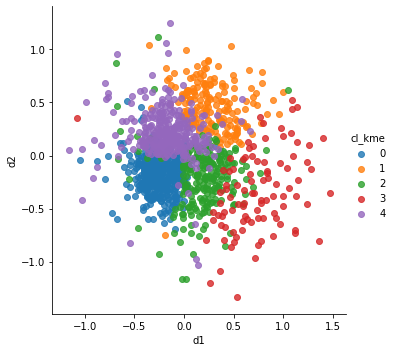

In [505]:
sns.lmplot(data=Xm,x='d1',y='d2',hue='cl_kme',fit_reg=False)
plt.savefig("Xm_Clusters.png")

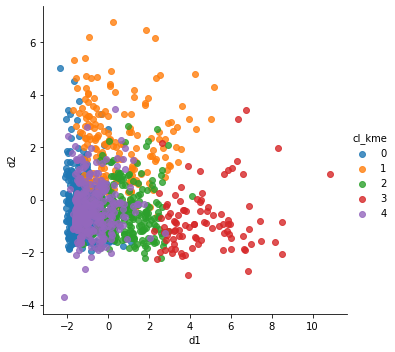

In [506]:
sns.lmplot(data=Xp,x='d1',y='d2',hue='cl_kme',fit_reg=False)
plt.savefig("Xp_Clusters.png")

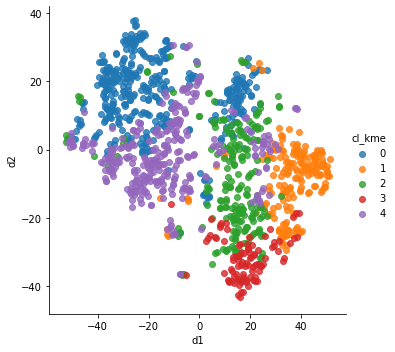

In [507]:
sns.lmplot(data=Xt,x='d1',y='d2',hue='cl_kme',fit_reg=False)
plt.savefig("Xt_Clusters.png")

## Scoring

In [511]:
pd.set_option('display.max_columns', 500)

In [1192]:
tad.head()

,Room Price,Number of reviews per month,Rooms rent by the host,Host Listings Count,Extra People,Minimum Nights,Number of Reviews,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Days since last review,Months of the product in Airbnb,Days since last update,Months Since is Host,Accommodates,Bathrooms,Bedrooms,Beds,Cancellation Policy,City,Country,Guests Included
0,70,0.04,1,1.0,0.0,1.0,2.0,100.0,10.0,9.0,10.0,9.0,10.0,10.0,326,10.966667,33,25.833333,2.0,1.0,1.0,1.0,flexible,Paris,France,1.0
1,44,0.95,1,1.0,0.0,5.0,2.0,80.0,8.0,9.0,8.0,8.0,8.0,9.0,347,11.866667,1,23.300000,2.0,1.0,1.0,1.0,flexible,Sydney,Australia,1.0
3,68,0.02,1,1.0,0.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,646,21.533333,33,49.266667,2.0,1.0,1.0,1.0,moderate,London,United kingdom,1.0
4,195,0.49,1,1.0,30.0,30.0,31.0,94.0,10.0,9.0,10.0,10.0,10.0,9.0,316,29.833333,33,30.500000,6.0,2.0,2.0,2.0,moderate,Paris,France,6.0
5,20,0.22,1,1.0,10.0,2.0,9.0,84.0,9.0,9.0,10.0,9.0,10.0,9.0,70,46.300000,29,46.933333,2.0,1.0,1.0,1.0,strict,Berlin,Germany,1.0


In [2573]:
dft = tad.copy()
dft = dft.dropna()
dft = dft[(dft["Room Price"]>=0)]

In [2574]:
dft["Accommodates"].describe()

count    38433.000000
mean         3.334842
std          1.848652
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         16.000000
Name: Accommodates, dtype: float64

In [2575]:
dft["Accommodates"].value_counts()/len(dft)

2.0     0.414279
4.0     0.223948
3.0     0.103609
6.0     0.081024
1.0     0.064112
5.0     0.057190
8.0     0.025057
7.0     0.015716
10.0    0.007858
9.0     0.004397
11.0    0.001093
12.0    0.000885
14.0    0.000286
16.0    0.000260
15.0    0.000156
13.0    0.000130
Name: Accommodates, dtype: float64

In [2576]:
(pd.cut(dft["Host Listings Count"], bins=[-1,1,12,18,24,36,10000]).astype(str).value_counts()/len(dft))

(-1, 1]        0.603154
(1, 12]        0.342388
(12, 18]       0.016730
(36, 10000]    0.014753
(24, 36]       0.012411
(18, 24]       0.010564
Name: Host Listings Count, dtype: float64

In [2577]:
def clean(df):
    
    df["Country"] = np.where(df["Country"].isin(["United states", "Italy", "France", "Spain", "Australia",
                                                  "Canada"]),df["Country"],"Others")
    
    df["City"] = np.where(df["City"].isin(["London", "Paris", "New york city", "Rome", "Copenhagen",
                                          "Los-angeles"]), df["City"], "Others")
    
    df["Cancellation Policy"] = np.where(df["Cancellation Policy"].str.find("strict") == 0,"strict",np.where
                                     (df["Cancellation Policy"].str.find("moderate") == 0,"moderate",np.where
                                    (df["Cancellation Policy"].str.find("flexible")==0,"flexible",
                                  "strict")))
    df["Bathrooms"] = np.where(df["Bathrooms"]<=1.0,"1 o menos","Mas de 1")
    df["Bedrooms"] = np.where(df["Bedrooms"].isin([0.0,1.0,2.0]),df["Bedrooms"], "Más de 2")
    df["Beds"] = np.where(df["Beds"].isin([1.0,2.0,3.0]),df["Beds"], "Más de 3")
    
    df["Accommodates"] = np.where(df["Accommodates"].astype(int)>4.0, "Más de 4", np.where
                                  (df["Accommodates"].astype(int)<=2, "2 o menos", df["Accommodates"]))
    df["Minimum Nights"] = np.where(df["Minimum Nights"]>4.0, "Más de 4", df["Minimum Nights"])
    df['Rooms rent by the host'] = np.where(df["Rooms rent by the host"]>3.0, "Más de 3", df["Rooms rent by the host"])

    df["Host Listings Count"] = np.where(df["Host Listings Count"]<=1.0, "Al menos 1", 
                                         np.where(df["Host Listings Count"] == 2.0, 2.0, "Más de 2"))
    df['Review Scores Cleanliness'] = np.where(df['Review Scores Cleanliness']<=8.0, "8 o menos", df['Review Scores Cleanliness'])
    df['Review Scores Accuracy'] = np.where(df['Review Scores Accuracy']<9.0, "Menor a 9", df['Review Scores Accuracy'])
    df['Review Scores Checkin'] = np.where(df['Review Scores Checkin']<9.0, "Menor a 9", df['Review Scores Checkin'])
    df['Review Scores Communication'] = np.where(df['Review Scores Communication']<9.0, "Menor a 9", df['Review Scores Communication'])
    df['Review Scores Location'] = np.where(df['Review Scores Location']<=8.0, "8 o menos", df['Review Scores Location'])
    df['Review Scores Value'] = np.where(df['Review Scores Value']<8.0, "Menor a 8", df['Review Scores Value'])
    df["Number of Reviews"] = np.where(df["Number of Reviews"]>4.0,"Más de 4", df["Number of Reviews"])
    df["Guests Included"] = np.where(df["Guests Included"]>4.0, "Más de 4", df["Guests Included"])
    df["Room Price"] = pd.cut(df["Room Price"], bins=[-1,50,100,200,500,10000000]).astype(str)
    df["Review Scores Rating"] = pd.cut(df["Review Scores Rating"], bins=[-1,85,90,95,97,99,100]).astype(str)
    df["Months of the product in Airbnb"] = pd.cut(df["Months of the product in Airbnb"], bins = [-1,6,12,18,24,36,10000]).astype(str)
    df["Months Since is Host"] = pd.cut(df["Months Since is Host"], bins = [-1,12,24,36,48,60,1000]).astype(str)
    df["Extra People"] = pd.cut(df["Extra People"], bins=[-1,0,1,10,20,1000]).astype(str)
    df["Days since last review"] = pd.cut(df["Days since last review"], bins=[-1,60,90,120,180,360,1000000]).astype(str)
    df["Days since last update"] = pd.cut(df["Days since last update"], bins=[-1,15,30,10000]).astype(str)
    
    return df

In [2578]:
dft = clean(dft)

In [2579]:
dft.head()

,Room Price,Number of reviews per month,Rooms rent by the host,Host Listings Count,Extra People,Minimum Nights,Number of Reviews,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Days since last review,Months of the product in Airbnb,Days since last update,Months Since is Host,Accommodates,Bathrooms,Bedrooms,Beds,Cancellation Policy,City,Country,Guests Included
0,"(50, 100]",0.04,1,Al menos 1,"(-1, 0]",1.0,2.0,"(99, 100]",10.0,9.0,10.0,9.0,10.0,10.0,"(180, 360]","(6, 12]","(30, 10000]","(24, 36]",2 o menos,1 o menos,1.0,1.0,flexible,Paris,France,1.0
1,"(-1, 50]",0.95,1,Al menos 1,"(-1, 0]",Más de 4,2.0,"(-1, 85]",Menor a 9,9.0,Menor a 9,Menor a 9,8 o menos,9.0,"(180, 360]","(6, 12]","(-1, 15]","(12, 24]",2 o menos,1 o menos,1.0,1.0,flexible,Others,Australia,1.0
4,"(100, 200]",0.49,1,Al menos 1,"(20, 1000]",Más de 4,Más de 4,"(90, 95]",10.0,9.0,10.0,10.0,10.0,9.0,"(180, 360]","(24, 36]","(30, 10000]","(24, 36]",Más de 4,Mas de 1,2.0,2.0,moderate,Paris,France,Más de 4
5,"(-1, 50]",0.22,1,Al menos 1,"(1, 10]",2.0,Más de 4,"(-1, 85]",9.0,9.0,10.0,9.0,10.0,9.0,"(60, 90]","(36, 10000]","(15, 30]","(36, 48]",2 o menos,1 o menos,1.0,1.0,strict,Others,Others,1.0
6,"(-1, 50]",0.48,1,2.0,"(-1, 0]",Más de 4,1.0,"(-1, 85]",Menor a 9,8 o menos,10.0,10.0,10.0,Menor a 8,"(90, 120]","(-1, 6]","(-1, 15]","(36, 48]",2 o menos,1 o menos,1.0,1.0,strict,Others,United states,1.0


In [2580]:
X = dft[varc+vard].copy()

X = X.dropna()

In [2581]:
X["Days since last review"].value_counts()/len(X)

(-1, 60]          0.212318
(180, 360]        0.211277
(360, 1000000]    0.193844
(60, 90]          0.156558
(120, 180]        0.125673
(90, 120]         0.100330
Name: Days since last review, dtype: float64

In [2582]:
#X["Target"] = np.where(np.percentile(X["Number of reviews per month"],90)<X["Number of reviews per month"],1,0)

X["Target"] = (X["Number of reviews per month"] > X["Number of reviews per month"].quantile(.7))*1
X = X.drop(["Number of reviews per month"], axis = 1)

In [2583]:
X.head()

,Room Price,Rooms rent by the host,Host Listings Count,Extra People,Minimum Nights,Number of Reviews,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Days since last review,Months of the product in Airbnb,Days since last update,Months Since is Host,Accommodates,Bathrooms,Bedrooms,Beds,Cancellation Policy,City,Country,Guests Included,Target
0,"(50, 100]",1,Al menos 1,"(-1, 0]",1.0,2.0,"(99, 100]",10.0,9.0,10.0,9.0,10.0,10.0,"(180, 360]","(6, 12]","(30, 10000]","(24, 36]",2 o menos,1 o menos,1.0,1.0,flexible,Paris,France,1.0,0
1,"(-1, 50]",1,Al menos 1,"(-1, 0]",Más de 4,2.0,"(-1, 85]",Menor a 9,9.0,Menor a 9,Menor a 9,8 o menos,9.0,"(180, 360]","(6, 12]","(-1, 15]","(12, 24]",2 o menos,1 o menos,1.0,1.0,flexible,Others,Australia,1.0,0
4,"(100, 200]",1,Al menos 1,"(20, 1000]",Más de 4,Más de 4,"(90, 95]",10.0,9.0,10.0,10.0,10.0,9.0,"(180, 360]","(24, 36]","(30, 10000]","(24, 36]",Más de 4,Mas de 1,2.0,2.0,moderate,Paris,France,Más de 4,0
5,"(-1, 50]",1,Al menos 1,"(1, 10]",2.0,Más de 4,"(-1, 85]",9.0,9.0,10.0,9.0,10.0,9.0,"(60, 90]","(36, 10000]","(15, 30]","(36, 48]",2 o menos,1 o menos,1.0,1.0,strict,Others,Others,1.0,0
6,"(-1, 50]",1,2.0,"(-1, 0]",Más de 4,1.0,"(-1, 85]",Menor a 9,8 o menos,10.0,10.0,10.0,Menor a 8,"(90, 120]","(-1, 6]","(-1, 15]","(36, 48]",2 o menos,1 o menos,1.0,1.0,strict,Others,United states,1.0,0


In [2584]:
X["Target"].value_counts()/len(X)

0    0.701038
1    0.298962
Name: Target, dtype: float64

In [2585]:
discrete_scores

['Review Scores Rating',
 'Review Scores Accuracy',
 'Review Scores Cleanliness',
 'Review Scores Checkin',
 'Review Scores Communication',
 'Review Scores Location',
 'Review Scores Value']

In [2586]:
discrete_scores = [i for i in X.columns if ((i.startswith("Review Scores")) )]
#& (i != "Review Scores Rating")
c_discrete_scores = ["C_" + i for i in discrete_scores]
X = X.rename(columns = dict({"Country": "C_Country", "Cancellation Policy":"C_Cancel Policy",
                       "Bathrooms":"C_Bathrooms", "Bedrooms":"C_Bedrooms",
                       "Beds":"C_Beds", "Accommodates": "C_Accommodates", "City": "C_City",
                       "Guests Included":"C_Guests Included", 
                       "Accommodates" : "C_Accommodates", "Minimum Nights" : "C_Minimum Nights", 
                       "Rooms rent by the host" : "C_Rooms rent by the host",
                       "Host Listings Count":"C_Host Listings Count",
                       "Number of Reviews":"C_Number of Reviews", "Guests Included": "C_Guests Included",
                       "Room Price":"C_Room Price",
                       "Months of the product in Airbnb" : "C_Months of the product in Airbnb",
                       "Months Since is Host" : "C_Months Since is Host",
                       "Days since last review" : "C_Days since last review",
                       "Extra People" : "C_Extra People", "Days since last update" : "C_Days since last update"}, 
                       
                        **dict(zip(discrete_scores,c_discrete_scores))))



In [2587]:
ls_cont

[]

In [2588]:
ls_cont = [i for i in X.columns if ((i != "Target") & (i.startswith("C_") == False))]

for var in ls_cont:
    X[f"C_{var}"] = pd.cut(X[var], bins=8).astype(str)

In [2589]:
def IV(df, var, tgt):
    aux = df[[var, tgt]].groupby(var).agg(["count", "sum"])
    aux["evento"] = aux[tgt, "sum"]
    aux["no_evento"] = aux[tgt, "count"] - aux[tgt, "sum"]
    aux["%evento"] = aux["evento"] / aux["evento"].sum()
    aux["%no_evento"] = aux["no_evento"] / aux["no_evento"].sum()
    aux["WOE"] = np.log(aux["%no_evento"] / aux["%evento"])
    aux["IV"] = (aux["%no_evento"] - aux["%evento"])*aux["WOE"]
    return aux["IV"].sum()

In [2590]:
new_disc = [x for x in X.columns if x.startswith("C_")]

tgt = "Target"

In [2591]:
df_iv = pd.DataFrame(columns=["iv"])

for var in new_disc:
    df_iv.loc[var, "iv"] = IV(df = X, var = var, tgt = tgt)

In [2592]:
df_iv.sort_values(by = "iv", ascending = False)

,iv
C_Days since last review,1.09876
C_Number of Reviews,0.852451
C_Review Scores Rating,0.518596
C_Minimum Nights,0.373854
C_City,0.275178
C_Country,0.259982
C_Rooms rent by the host,0.155763
C_Host Listings Count,0.150407
C_Review Scores Cleanliness,0.141083
C_Room Price,0.138012


In [2593]:
ls_best = df_iv[df_iv["iv"] != np.inf].sort_values(by = "iv", ascending=False).head(10).index

In [2594]:
def WOE(df, var, tgt):
    aux = df[[var, tgt]].groupby(var).agg(["count", "sum"])
    aux["evento"] = aux[tgt, "sum"]
    aux["no_evento"] = aux[tgt, "count"] - aux[tgt, "sum"]
    aux["%evento"] = aux["evento"] / aux["evento"].sum()
    aux["%no_evento"] = aux["no_evento"] / aux["no_evento"].sum()
    aux["WOE"] = np.log(aux["%no_evento"] / aux["%evento"])
    aux.columns = aux.columns.droplevel(1)
    aux = aux[["WOE"]].reset_index().rename(columns={"WOE": f"W_{var}"})
    df = df.merge(aux, on = var, how = "left")
    return df

In [2595]:
for var in ls_best:
    X = WOE(df = X, var = var, tgt = tgt)

In [2603]:
def metricas(X,y,modelo):
    print("ACC: ", accuracy_score(y_true=y,y_pred=modelo.predict(X))) 
    print("ROC: ", roc_auc_score(y_true=y,y_score=modelo.predict_proba(X)[:,1]))
    print(" ")

In [2623]:
ls_woe = [x for x in X.columns if x.startswith("W_")]

y = X[tgt]
Xr = X[ls_woe]

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score,roc_curve

logreg = LogisticRegression()

Xt,Xv,yt,yv = train_test_split(Xr,y,train_size=0.7)

logreg.fit(Xt, yt)

print(logreg.score(Xt, yt))
print(logreg.score(Xv, yv))

print(" ")
print("Metrics")

print(metricas(Xt, yt, logreg))
print(metricas(Xv, yv, logreg))

/Users/Victor/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7976062149202691
0.7961838681699913
 
Metrics
ACC:  0.7976062149202691
ROC:  0.8602456126226656
 
None
ACC:  0.7961838681699913
ROC:  0.8538652923102427
 
None


In [2624]:
pdo = 30
base_score = 171
base_odds = 100
factor = pdo/np.log(2)
offset = base_score - (factor - np.log(base_odds))
m = len(ls_woe)

In [2625]:
alpha = logreg.intercept_
betas = logreg.coef_[0]

In [2626]:
for feat, beta in zip(ls_woe, betas):
    X["P_" + feat[2:]] = X[feat].apply(lambda x:((-beta*x + (alpha/m))*factor) + (offset/m)).astype(int)

In [2627]:
X["score"] = X[[x for x in X.columns if x.startswith("P_")]].sum(axis = 1)

In [2628]:
X["score"].describe()

count    38433.000000
mean       117.862800
std         83.693283
min        -31.000000
25%         46.000000
50%        110.000000
75%        183.000000
max        402.000000
Name: score, dtype: float64

In [2629]:
sigmoid_X = X.sample(frac = 0.001)
sigmoid_X["Target"].value_counts()

0    27
1    11
Name: Target, dtype: int64

In [2630]:
len(sigmoid_X)

38

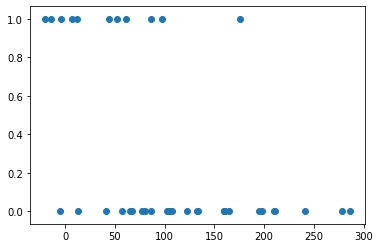

In [2631]:
plt.scatter(sigmoid_X["score"], sigmoid_X["Target"])

In [2632]:
X[X["score"] <20]["Target"].value_counts()/len(X[X["score"] <20])

1    0.754752
0    0.245248
Name: Target, dtype: float64

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.860


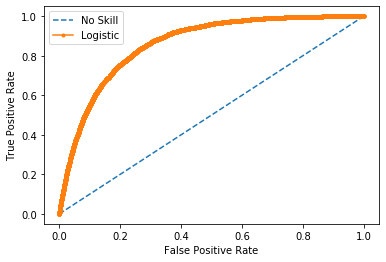

In [2639]:
lr_probs = logreg.predict_proba(Xt)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
ns_probs = [0 for _ in range(len(yt))]
# calculate scores
ns_auc = roc_auc_score(yt, ns_probs)
lr_auc = roc_auc_score(yt, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(yt, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(yt, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [2562]:
def plot_histogram(data, n_bins = 15):
    freq, bins = np.histogram(data, bins=n_bins)
    hist = pygal.Histogram()
    hist.add('Wide bars', list(zip(freq, bins, bins[1:])))
    return hist

ValueError: unknown locale: UTF-8

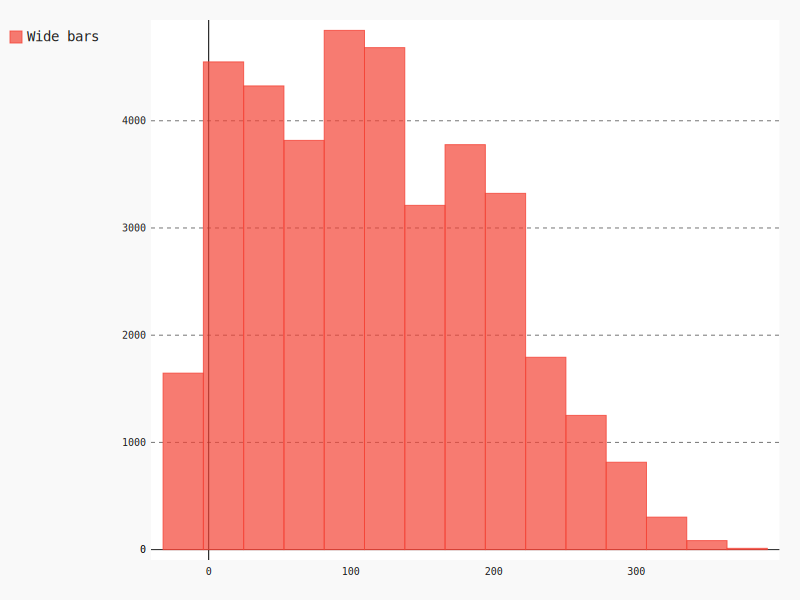

In [2563]:
import pygal

plot_histogram(X["score"])

In [2564]:
ls_best_raw = [x[2:] for x in ls_best]

In [2565]:
for var in ls_best:
    display(X[[var, "P_" + var]].groupby(var).last())

,P_C_Days since last review
C_Days since last review,
"(-1, 60]",-30
"(120, 180]",41
"(180, 360]",51
"(360, 1000000]",56
"(60, 90]",-22
"(90, 120]",2


,P_C_Number of Reviews
C_Number of Reviews,
1.0,64
2.0,58
3.0,54
4.0,47
Más de 4,-3


,P_C_Review Scores Rating
C_Review Scores Rating,
"(-1, 85]",26
"(85, 90]",11
"(90, 95]",4
"(95, 97]",0
"(97, 99]",-6
"(99, 100]",25


,P_C_Minimum Nights
C_Minimum Nights,
1.0,-2
2.0,0
3.0,13
4.0,47
Más de 4,80


,P_C_City
C_City,
Copenhagen,27
London,14
Los-angeles,5
Others,8
Paris,15
Rome,3


,P_C_Country
C_Country,
Australia,14
Canada,9
France,19
Italy,-1
Others,17
Spain,0
United states,2


,P_C_Rooms rent by the host
C_Rooms rent by the host,
1,16
2,1
3,-4
Más de 3,-2


,P_C_Host Listings Count
C_Host Listings Count,
2.0,5
Al menos 1,13
Más de 2,3


,P_C_Review Scores Cleanliness
C_Review Scores Cleanliness,
10.0,6
8 o menos,36
9.0,8


,P_C_Room Price
C_Room Price,
"(-1, 50]",9
"(100, 200]",6
"(200, 500]",23
"(50, 100]",2
"(500, 10000000]",57
